# Model Tuning

Now that I have established that I can train a model to drive the car, I will start building a CNN that can successfully complete a lap.
I have learned much from [this article by Jason Brownlee on the subject](https://machinelearningmastery.com/deep-learning-models-for-multi-output-regression/), which was linked to me by my DSI-830 instructor Patrick Waled-Dinian

Plan:
* Import numpy arrays X and y 
* Create train-test split
* Assemble a Convolutional Neural Network
* Use KerasTuner to find optimal hyperparameters
* Fit and assess CNN
* Save model to test driving

In [1]:
## Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import time

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from keras_tuner import BayesianOptimization, Hyperband, HyperModel

from os.path import exists

from tensorflow import keras
from tensorflow.keras.backend import concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, Flatten
from tensorflow.keras.metrics import MAE, MSE
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2021-11-09 18:36:02.995110: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
## Constants
working_date = '11_08_2021'
working_time = '22_04_06'

model_history_file = '../models/model_history.csv'

In [3]:
## Directories
data_directory = f'../data/{working_date}/{working_time}'
model_directory = f'../models/{working_date}/{working_time}'

## File paths
input_dataset_file = f'{data_directory}/X.npy'
target_dataset_file = f'{data_directory}/y.npy'

In [4]:
## Make sure model history exists
if not exists(model_history_file):
    model_history = pd.DataFrame(columns=['model', 'history', 
                                          'r2_score', 'mae_score',
                                          'mse_score', 'rmse_score'])
else:
    model_history = pd.read_csv(model_history_file, index_col=0)

## Data

### Load Datasets

In [5]:
## Load the datasets
X = np.load(input_dataset_file)
y = np.load(target_dataset_file)

### Create Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, random_state=0)

## Model

sources: 

* [Introduction to the Keras Tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
* [Hands on hyperparameter tuning with Keras Tuner](https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner) by Julie Prost

Hyperparameters:
* Number of convolutional layers
* number of filters
* size of filters
* number of dense layers
* units in dense layers
* dropout values
* adam learning rate

### Create Framework

In [11]:
## Lesson 8.03
## https://docs.donkeycar.com/dev_guide/model/

class VIMUHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        kernels = [3, 5, 7,]
        filters = [8, 16, 32, 64,]
        units = [8, 16, 32, 64,]
        drops = [0.0, 0.1, 0.2, 0.3]
        strides = [1, 2]
        
        ## Image Model
        inputs = Input(shape=img_shape, name='inputs')
        
        layers = Conv2D(
                filters=hp.Choice(f'filters_0',values=filters), 
                kernel_size=hp.Choice(f'kernel_0', values=kernels),
                strides=hp.Choice(f'stride_0', values=strides)
            )(inputs)
        
        # Load convolutional models        
        for n in range(1, 5):
            # Add conv
            layers = Conv2D(
                filters=hp.Choice(f'filters_{n}',values=filters), 
                kernel_size=hp.Choice(f'kernel_{n}', values=kernels),
                strides=hp.Choice(f'stride_{n}', values=strides)
            )(layers)
            # Add dropout
            layers = Dropout(
                rate=hp.Choice(f'drop_{n}', values=drops)
            )(layers)
            
            
        ## Flatten
        layers.add(Flatten())
        
        ## First Dense Layer
        layers = Dense(units=hp.Choice('units_5', values=units), 
                       activation='relu'
                      )(layers)
        layers = Dropout(rate=hp.Choice('drop_5', values=drops))(layers)

        inputs.add(
            Dense(
                units=hp.Choice(
                    'units_2',
                    values=n_units
                ),
                activation='relu'
            )
        )
        inputs.add(
            Dropout(
                rate=hp.Choice(
                    'dense_dropout_2', 
                    values=dense_dropout_rates
                )
            )
        )
        
        outputs = [
            Dense(1, activation='linear', name='steering_out')(inputs)
            
            


        ## Output Layer
        model.add(Dense(2, activation='linear'))
        
        ## Compile Model
        model.compile(
            optimizer=Adam(
                # hp.Float(
                #     'learning_rate',
                #     min_value=1e-4,
                #     max_value=1e-2,
                #     sampling='LOG',
                # )
            ),
            loss=MAE,
            # metrics=[MSE]
            # loss=MSE,
            # metrics=[MAE]
        )
        
        return model

In [12]:
input_shape = X_train[0].shape

### Create Tuner

In [13]:
hypermodel = FixedLayersCNNHyperModel(input_shape)

# tuner = BayesianOptimization(hypermodel, 
#                              objective='val_loss',
#                              beta=2.7,
#                              max_trials=100, 
#                              seed=0, overwrite=True)

tuner = Hyperband(hypermodel, 
                  objective='val_loss',
                  max_epochs=25,
                  factor=3,
                  hyperband_iterations=2, 
                  seed=0,
                  overwrite=True,);

2021-11-09 18:36:06.076919: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-09 18:36:06.077644: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-11-09 18:36:06.111351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-09 18:36:06.111599: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.797GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2021-11-09 18:36:06.111616: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-11-09 18:36:06.112878: I tensorflow/stream_executor/platfor

### Search

In [14]:
stop_early = EarlyStopping(patience=5)

In [15]:
tuner.search(X_train, y_train, 
             validation_data=(X_test, y_test), 
             callbacks=[stop_early],
             batch_size=32, 
             verbose=1)

Trial 60 Complete [00h 01m 28s]
val_loss: 0.14088742434978485

Best val_loss So Far: 0.07812678813934326
Total elapsed time: 00h 41m 14s
INFO:tensorflow:Oracle triggered exit


### Fit

In [32]:
## https://www.tensorflow.org/tutorials/keras/keras_tuner
best_hps = tuner.get_best_hyperparameters(1)[0]
model = tuner.hypermodel.build(best_hps)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 76, 56, 64)        1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 48, 16)        82960     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 24, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 34, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 18, 32)        25120     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 7, 64)         0

In [34]:
##  
results = model.fit(X_train, 
                    y_train, 
                    batch_size=16, 
                    epochs=500, 
                    validation_data=(X_test, y_test), 
                    callbacks=[stop_early])

Epoch 1/500
526/526 [==============================] - 8s 14ms/step - loss: 0.3054 - val_loss: 0.1785
Epoch 2/500
526/526 [==============================] - 7s 14ms/step - loss: 0.1928 - val_loss: 0.1202
Epoch 3/500
526/526 [==============================] - 7s 13ms/step - loss: 0.1656 - val_loss: 0.1262
Epoch 4/500
526/526 [==============================] - 7s 13ms/step - loss: 0.1492 - val_loss: 0.1314
Epoch 5/500
526/526 [==============================] - 7s 13ms/step - loss: 0.1360 - val_loss: 0.1140
Epoch 6/500
526/526 [==============================] - 7s 13ms/step - loss: 0.1282 - val_loss: 0.1196
Epoch 7/500
526/526 [==============================] - 7s 14ms/step - loss: 0.1238 - val_loss: 0.1220
Epoch 8/500
526/526 [==============================] - 7s 14ms/step - loss: 0.1157 - val_loss: 0.1213
Epoch 9/500
526/526 [==============================] - 7s 14ms/step - loss: 0.1062 - val_loss: 0.1034
Epoch 10/500
526/526 [==============================] - 7s 14ms/step - loss: 0.104

In [19]:
model.evaluate(X_train, y_train)

263/263 [==============================] - 1s 5ms/step - loss: 0.0923


0.09227794408798218

In [20]:
model.evaluate(X_test, y_test)

14/14 [==============================] - 0s 5ms/step - loss: 0.1043


0.10427911579608917

In [21]:
results.history.keys()

dict_keys(['loss', 'val_loss'])

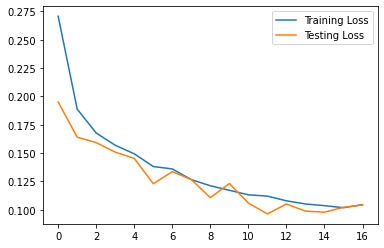

In [22]:
plt.plot(results.history['loss'], label = 'Training Loss')
plt.plot(results.history['val_loss'], label = 'Testing Loss')
plt.legend();

In [23]:
# plt.plot(results.history['mean_absolute_error'], label = 'Training MAE')
# plt.plot(results.history['val_mean_absolute_error'], label = 'Testing MAE')
# plt.legend();

In [24]:
preds = model.predict(X_test)

In [25]:
## r2 
print(f'Train R2: {metrics.r2_score(y_train, model.predict(X_train))}')
print(f'Test R2: {metrics.r2_score(y_test, preds)}')

Train R2: 0.8303425543600481
Test R2: 0.7603535981448071


In [26]:
## MAE
print(f'Train MAE: {metrics.mean_absolute_error(y_train, model.predict(X_train))}')
print(f'Test MAE: {metrics.mean_absolute_error(y_test, preds)}')

Train MAE: 0.0922781378030777
Test MAE: 0.10427909344434738


In [27]:
## MSE
print(f'Train MSE: {metrics.mean_squared_error(y_train, model.predict(X_train))}')
print(f'Test MSE: {metrics.mean_squared_error(y_test, preds)}')

Train MSE: 0.025798149406909943
Test MSE: 0.033954501152038574


In [28]:
## RMSE
print(f'Train RMSE: {metrics.mean_squared_error(y_train, model.predict(X_train), squared=False)}')
print(f'Test RMSE: {metrics.mean_squared_error(y_test, preds, squared=False)}')

Train RMSE: 0.15965671837329865
Test RMSE: 0.18092986941337585


## Save model

In [29]:
model_index = max(0, model_history.index.max() + 1)
model_path = f'{model_directory}/model_{model_index}.h5'

history_dictionary = {
    'model': model_path,
    'history': results.history,
    'r2_score': metrics.r2_score(y_test, preds),
    'mae_score': metrics.mean_absolute_error(y_test, preds),
    'mse_score': metrics.mean_squared_error(y_test, preds),
    'rmse_score': metrics.mean_squared_error(y_test, preds, squared=False),
}

model_history = model_history.append(history_dictionary, ignore_index=True)
model_history.tail()

,model,history,mae_score,mse_score,r2_score,rmse_score
20,../models/11_08_2021/22_04_06/model_20.h5,"{'loss': [0.040462393313646317, 0.022811815142...",0.078037,0.014810,0.896010,0.119186
21,../models/11_08_2021/22_04_06/model_21.h5,"{'loss': [0.10135098546743393, 0.0428961552679...",0.073959,0.013642,0.902857,0.115144
22,../models/11_08_2021/22_04_06/model_22.h5,"{'loss': [0.30126410722732544, 0.1519710421562...",0.158894,0.043945,0.686996,0.206681
23,../models/11_08_2021/22_04_06/model_23.h5,"{'loss': [0.19611622393131256, 0.1452387720346...",0.174809,0.086396,0.409337,0.283149
24,../models/11_08_2021/22_04_06/model_24.h5,"{'loss': [0.27067601680755615, 0.1887831091880...",0.104279,0.033955,0.760354,0.180930


In [30]:
## Saving as h5 for backwards compatibility
model.save(model_path, save_format='h5')
model_history.to_csv(model_history_file)

In [31]:
model_path

'../models/11_08_2021/22_04_06/model_24.h5'